In [271]:
# some ideas just for curiosity:
# - could train an RL model to predict what dominoes are in other agents hands based on what has been played, their line, and what is available...
# - for hand-crafted networks, I wonder if graph theory methods can speed up the line-value estimation methods...

In [1]:
%reload_ext autoreload
%autoreload 2

import time
from copy import copy
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
import dominoesGameplay as dg
import dominoesAgents as da
import dominoesNetworks as dn
import dominoesFunctions as df
import fileManagement as fm

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [344]:
# Specific Updates to Value Agents --
# - I don't think I need to estimate pre/post states every play. This will save so much computation time, and may even be easier for the agents to learn. 
# - !! It seems like I do need to estimate pre/post states every play. However, I think there's an alternative solution:
#         - instead of measuring TD error between the pre & post state, I can measure TD error between the pre-state and the next agent turn's pre-state.
#         - this way, the agent will be able to build longer-term connections, but will still only estimate value once per round of turns...

# Blog Post Planning: 
# 1. Creating a system that plays dominoes
# 2. Hand-crafted agents that play with specific rules
# 3. Finding a way to represent the game-state in a way that can be fed to a neural network
#    3.1 -- Simple networks can't learn how to do addition and biased subtraction...?
# 4. Adding information to the game-state about possible line sequences for the network to use more information in deciding how to play
#    4.1 -- comparing performance of the lineValueNetwork where it is trained against bad agents or good agents
#    4.2 -- comparing performance of the lineValueNetwork when it uses pre-poststate updates on every turn, only it's own turn, or only on it's own turn but before/after all other agents have had their turn...
# 5. Building a neural network that can outperform the line value networks without hand-crafted information (e.g. a Transformer)

In [ ]:
# initialize game, and create agents
# train lineValue agent against greedy agents (which it can learn to beat easily)
numPlayers = 4
highestDominoe = 9
game = dg.dominoeGame(highestDominoe, numPlayers=numPlayers, agents=(da.lineValueAgentSmall, da.greedyAgent, da.greedyAgent, da.greedyAgent), device=device)

# run training rounds
trainingGames = 500
trainingRounds = 50
trainingWinnerCount = np.zeros(numPlayers)
trainingScoreTally = np.zeros((trainingGames,numPlayers))
for gameIdx in tqdm(range(trainingGames)):
    game.playGame(rounds=trainingRounds)
    trainingWinnerCount[game.currentWinner] += 1
    trainingScoreTally[gameIdx] += game.currentScore

# measure performance
game.agents[0].setLearning(False)
performanceGames = 10
performanceRounds = 50
performanceWinnerCount = np.zeros(numPlayers)
performanceScoreTally = np.zeros(numPlayers)
for _ in tqdm(range(performanceGames)):
    game.playGame(rounds=performanceRounds)
    performanceWinnerCount[game.currentWinner] += 1 
    performanceScoreTally += game.currentScore


 88%|████████████████████████████████████████████████████████████████████▉         | 442/500 [2:19:23<10:27, 10.82s/it]

In [ ]:
# save intermediary agent: 
game.getAgent(0).saveAgentParameters(fm.savePath())

In [ ]:
# report results of training lineValueAgent against greedyAgents
print(f"Games won: {performanceWinnerCount}")
print(f"Expected score per hand: {performanceScoreTally / performanceGames / performanceRounds}")
c = ['r','g','b','k']
for i in range(4):
    plt.plot(range(trainingGames), trainingScoreTally[:,i]/trainingRounds, c=c[i])

In [25]:
# initialize new game
# keep lineValueAgent (load previously learned parameters from playing against greedyAgents), and have it play against bestLineAgents

numPlayers = 4
highestDominoe = 9
game = dg.dominoeGame(highestDominoe, numPlayers=numPlayers, agents=(da.lineValueAgentSmall, da.bestLineAgent, da.bestLineAgent, da.bestLineAgent), device=device)

fileName = 'lineValueAgentParameters_230809_0.npy'
game.getAgent(0).loadAgentParameters(fm.savePath() / fileName)
game.getAgent(0).setLearning(True)

# run training rounds
trainingGames = 500
trainingRounds = 50
trainingWinnerCount = np.zeros(numPlayers)
trainingScoreTally = np.zeros((trainingGames,numPlayers))
for gameIdx in tqdm(range(trainingGames)):
    game.playGame(rounds=trainingRounds)
    trainingWinnerCount[game.currentWinner] += 1
    trainingScoreTally[gameIdx] += game.currentScore

# measure performance
game.getAgent(0).setLearning(False)
performanceGames = 10
performanceRounds = 50
performanceWinnerCount = np.zeros(numPlayers)
performanceScoreTally = np.zeros(numPlayers)
for _ in tqdm(range(performanceGames)):
    game.playGame(rounds=performanceRounds)
    performanceWinnerCount[game.currentWinner] += 1 
    performanceScoreTally += game.currentScore

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:34<00:00,  9.46s/it]


In [ ]:
# save final agent: 
# game.getAgent(0).saveAgentParameters(fm.savePath())

Games won: [0. 5. 4. 1.]
Expected score per hand: [14.696 10.066 10.088 10.962]


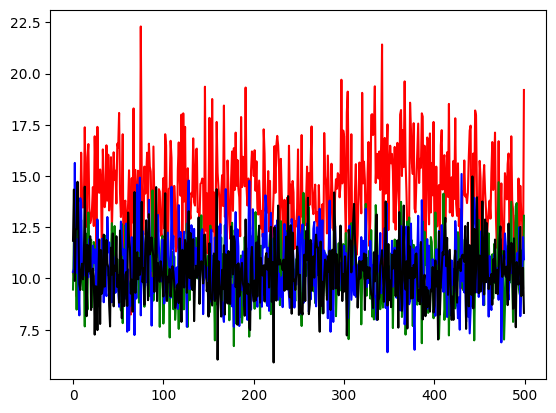

In [27]:
# report results of training lineValueAgent against greedyAgents
print(f"Games won: {performanceWinnerCount}")
print(f"Expected score per hand: {performanceScoreTally / performanceGames / performanceRounds}")
c = ['r','g','b','k']
for i in range(4):
    plt.plot(range(trainingGames), trainingScoreTally[:,i]/trainingRounds, c=c[i])

In [35]:
# initialize game, and create agents
numPlayers = 4
highestDominoe = 9

agents=(da.lineValueAgent, da.bestLineAgent, da.bestLineAgent, da.bestLineAgent)
game = dg.dominoeGame(highestDominoe, numPlayers=numPlayers, agents=agents, defaultAgent=da.dominoeAgent, device=device)

fileName = 'lineValueAgentParameters_230802_0.npy'
game.agents[0].loadAgentParameters(fm.savePath() / fileName)
game.agents[0].setLearning(False)

# measure performance without learning
performanceGames = 15
performanceRounds = 10
performanceWinnerCount = np.zeros(numPlayers)
performanceScoreTally = np.zeros(numPlayers)
for _ in tqdm(range(performanceGames)):
    game.playGame(rounds=performanceRounds)
    performanceWinnerCount[game.currentWinner] += 1 
    performanceScoreTally += game.currentScore
    
print(f"Games won: {performanceWinnerCount}")
print(f"Expected score per hand: {np.round(performanceScoreTally / performanceGames / performanceRounds * 100)/100}")

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:36<00:00,  2.47s/it]

Games won: [9. 3. 1. 2.]
Expected score per hand: [ 8.61 12.58 12.08 12.14]


In [49]:
# game.getAgent(0).saveAgentParameters(fm.savePath())

Describe this model briefly:  In this model, I pretrained it to learn while playing double agents, then trained it against best line agents. 


In [49]:
from pointerNetwork import AttentionLayer, TransformerBlock

batchSize = 10
seqLength = 15
emb = 24
att = AttentionLayer(emb)
trans = TransformerBlock(emb, 4, None, seqLength)
x = torch.normal(0,1,(batchSize, seqLength, emb))

out = att(x)
t = trans(x)

print(x.shape)
print(out.shape)
print(t.shape)

torch.Size([10, 15, 24])
torch.Size([10, 15, 24])
torch.Size([10, 15, 24])


In [47]:
xx = nn.Linear(24, 50)

In [48]:
xx(out).shape

torch.Size([10, 15, 50])

In [3]:
from torch.autograd import Variable

def createData(total_size, input_seq_len):
    input, targets = make_seq_data(total_size, input_seq_len)
    return input, targets

def prepareData(input, targets, total_size):
    # Convert to torch tensors
    input = to_var(torch.LongTensor(input))     # (N, L)
    targets = to_var(torch.LongTensor(targets)) # (N, L)

    data_split = (int)(total_size * 0.9)
    train_X = input[:data_split]
    train_Y = targets[:data_split]
    test_X = input[data_split:]
    test_Y = targets[data_split:]
    
    return input, targets, train_X, train_Y, test_X, test_Y

# from pointer_network import PointerNetwork
def train(model, X, Y, batch_size, n_epochs):
    model.train()
    optimizer = torch.optim.Adam(model.parameters())
    N = X.size(0)
    L = X.size(1)
    # M = Y.size(1)
    for epoch in range(n_epochs + 1):
        # for i in range(len(train_batches))
        for i in range(0, N-batch_size, batch_size):
            x = X[i:i+batch_size] # (bs, L)
            y = Y[i:i+batch_size] # (bs, M)

            probs = model(x) # (bs, M, L)
            outputs = probs.view(-1, L) # (bs*M, L)
            # outputs = probs.view(L, -1).t().contiguous() # (bs*M, L)
            y = y.view(-1) # (bs*M)
            loss = F.nll_loss(outputs, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if epoch % 2 == 0:
            print('epoch: {}, Loss: {:.5f}'.format(epoch, loss.item()))
            # for _ in range(2): # random showing results
            #     pick = np.random.randint(0, batch_size)
            #     probs = probs.contiguous().view(batch_size, M, L).transpose(2, 1) # (bs, L, M)
            #     y = y.view(batch_size, M)
            #     print("predict: ", probs.max(1)[1].data[pick][0], probs.max(1)[1].data[pick][1],
            #           "target  : ", y.data[pick][0], y.data[pick][1])
            test(model, X, Y)

def test(model, X, Y):
    probs = model(X) # (bs, M, L)
    _v, indices = torch.max(probs, 2) # (bs, M)
    # show test examples
    # for i in range(len(indices)):
    #     print('-----')
    #     print('test', [v for v in X[i].data])
    #     print('label', [v for v in Y[i].data])
    #     print('pred', [v for v in indices[i].data])
    #     if torch.equal(Y[i].data, indices[i].data):
    #         print('eq')
    #     if i>20: break
    correct_count = sum([1 if torch.equal(ind.data, y.data) else 0 for ind, y in zip(indices, Y)])
    print('Acc: {:.2f}% ({}/{})'.format(correct_count/len(X)*100, correct_count, len(X)))
    
def generate_single_seq(length=30, min_len=5, max_len=10):
    # https://medium.com/@devnag/pointer-networks-in-tensorflow-with-sample-code-14645063f264
    """ Generates a sequence of numbers of random length and inserts a sub-sequence oh greater numbers at random place
    Input:
    length: total sequence length
    min_len: minimum length of sequence
    max_len: maximum length of sequence
    Output:
    sequence of numbers, index of the start of greater numbers subsequence"""
    seq_before = [(random.randint(1, 5)) for x in range(random.randint(min_len, max_len))]
    seq_during = [(random.randint(6, 10)) for x in range(random.randint(min_len, max_len))]
    seq_after = [random.randint(1, 5) for x in range(random.randint(min_len, max_len))]
    seq = seq_before + seq_during + seq_after
    seq = seq + ([0] * (length - len(seq)))
    return (seq, len(seq_before), len(seq_before) + len(seq_during)-1)

def generate_set_seq(N):
    # generate Boundary tasks
    """Generates a set of N sequences of fixed length"""
    data = []
    starts = []
    ends = []
    for i in range(N):
        seq, ind_start, ind_end = generate_single_seq()
        data.append(seq)
        starts.append(ind_start)
        ends.append(ind_end)
    return data, starts, ends

def make_seq_data(n_samples, seq_len):
    # Boundary tasks
    data, labels = [], []
    for _ in range(n_samples):
        input = np.random.permutation(range(seq_len)).tolist()
        target = sorted(range(len(input)), key=lambda k: input[k])
        data.append(input)
        labels.append(target)
    return data, labels

def to_var(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

class PointerNetwork(nn.Module):
    def __init__(self, input_size, emb_size, weight_size, answer_seq_len, hidden_size=512, is_GRU=True):
        super(PointerNetwork, self).__init__()

        self.hidden_size = hidden_size
        self.input_size = input_size
        self.answer_seq_len = answer_seq_len
        self.weight_size = weight_size
        self.emb_size = emb_size
        self.is_GRU = is_GRU

        self.emb = nn.Embedding(input_size, emb_size)  # embed inputs
        if is_GRU:
            self.enc = nn.GRU(emb_size, hidden_size, batch_first=True)
            self.dec = nn.GRUCell(emb_size, hidden_size) # GRUCell's input is always batch first
        else:
            self.enc = nn.LSTM(emb_size, hidden_size, batch_first=True)
            self.dec = nn.LSTMCell(emb_size, hidden_size) # LSTMCell's input is always batch first

        self.W1 = nn.Linear(hidden_size, weight_size, bias=False) # blending encoder
        self.W2 = nn.Linear(hidden_size, weight_size, bias=False) # blending decoder
        self.vt = nn.Linear(weight_size, 1, bias=False) # scaling sum of enc and dec by v.T

    def forward(self, input, printShapes=False):
        if printShapes: print(f"Input shape: {input.shape}")
        batch_size = input.size(0)
        input = self.emb(input) # (bs, L, embd_size)
        
        if printShapes: print(f"Embedding shape: {input.shape}")
        
        # Encoding
        encoder_states, hc = self.enc(input) # encoder_state: (bs, L, H)
        encoder_states = encoder_states.transpose(1, 0) # (L, bs, H)
        
        if printShapes: print(f"Encoder_states shape: {encoder_states.shape}")
        if printShapes: print(f"hc shape: {hc.shape}")
        
        # Decoding states initialization
        decoder_input = to_var(torch.zeros(batch_size, self.emb_size)) # (bs, embd_size)
        hidden = to_var(torch.zeros([batch_size, self.hidden_size]))   # (bs, h)
        cell_state = encoder_states[-1]                                # (bs, h)
        
        if printShapes: print(f"decoder_input shape: {decoder_input.shape}")
        if printShapes: print(f"hidden shape: {hidden.shape}")
        if printShapes: print(f"cell_state shape: {cell_state.shape}")
        if printShapes: print(f"\nNow at decoding layer: \n")
        probs = []
        # Decoding
        for i in range(self.answer_seq_len): # range(M)
            if self.is_GRU:
                hidden = self.dec(decoder_input, hidden) # (bs, h), (bs, h)
                if printShapes: print(f"hidden shape: {hidden.shape}")
            else:
                hidden, cell_state = self.dec(decoder_input, (hidden, cell_state)) # (bs, h), (bs, h)
                if printShapes: print(f"hidden shape: {hidden.shape}")
                if printShapes: print(f"cell_state shape: {cell_state.shape}")
            
            # Compute blended representation at each decoder time step
            blend1 = self.W1(encoder_states)          # (L, bs, W)
            blend2 = self.W2(hidden)                  # (bs, W)
            blend_sum = torch.tanh(blend1 + blend2)    # (L, bs, W)
            out = self.vt(blend_sum).squeeze()        # (L, bs)
            out = F.log_softmax(out.transpose(0, 1).contiguous(), -1) # (bs, L)
            probs.append(out)
            
            if printShapes: print(f"blend1 shape: {blend1.shape}")
            if printShapes: print(f"blend2 shape: {blend2.shape}")
            if printShapes: print(f"blend_sum shape: {blend_sum.shape}")
            if printShapes: print(f"out shape: {out.shape}")

        probs = torch.stack(probs, dim=1)           # (bs, M, L)

        return probs

total_size = 10000
weight_size = 256
input_seq_len = 5
emb_size = 256
batch_size = 250
n_epochs = 5
inp_size = input_seq_len

input, targets = createData(total_size, input_seq_len)
input, targets, train_X, train_Y, test_X, test_Y = prepareData(input, targets, total_size)
model = PointerNetwork(inp_size, emb_size, weight_size, input_seq_len)
if torch.cuda.is_available(): model.cuda()
train(model, train_X, train_Y, batch_size, n_epochs)
print('----Test result---')
test(model, test_X, test_Y)

epoch: 0, Loss: 0.24199
Acc: 100.00% (9000/9000)
epoch: 2, Loss: 0.00185
Acc: 100.00% (9000/9000)
epoch: 4, Loss: 0.00092
Acc: 100.00% (9000/9000)
----Test result---
Acc: 100.00% (1000/1000)


In [4]:
probs = model.forward(test_X[:8], printShapes=True) # (bs, M, L)
_v, indices = torch.max(probs, 2) # (bs, M)
# show test examples
for i in range(len(indices)):
    print('-----')
    print(f'test:  {test_X[i].detach().cpu().numpy()}')
    print(f'label: {test_Y[i].detach().cpu().numpy()}')
    print(f'pred:  {indices[i].detach().cpu().numpy()}')
    if i>20: break
correct_count = sum([1 if torch.equal(ind.data, y.data) else 0 for ind, y in zip(indices, test_Y)])
print('Acc: {:.2f}% ({}/{})'.format(correct_count/len(test_X)*100, correct_count, len(test_X)))

Input shape: torch.Size([8, 5])
Embedding shape: torch.Size([8, 5, 256])
Encoder_states shape: torch.Size([5, 8, 512])
hc shape: torch.Size([1, 8, 512])
decoder_input shape: torch.Size([8, 256])
hidden shape: torch.Size([8, 512])
cell_state shape: torch.Size([8, 512])

Now at decoding layer: 

hidden shape: torch.Size([8, 512])
blend1 shape: torch.Size([5, 8, 256])
blend2 shape: torch.Size([8, 256])
blend_sum shape: torch.Size([5, 8, 256])
out shape: torch.Size([8, 5])
hidden shape: torch.Size([8, 512])
blend1 shape: torch.Size([5, 8, 256])
blend2 shape: torch.Size([8, 256])
blend_sum shape: torch.Size([5, 8, 256])
out shape: torch.Size([8, 5])
hidden shape: torch.Size([8, 512])
blend1 shape: torch.Size([5, 8, 256])
blend2 shape: torch.Size([8, 256])
blend_sum shape: torch.Size([5, 8, 256])
out shape: torch.Size([8, 5])
hidden shape: torch.Size([8, 512])
blend1 shape: torch.Size([5, 8, 256])
blend2 shape: torch.Size([8, 256])
blend_sum shape: torch.Size([5, 8, 256])
out shape: torch.Si

## Below this point I'm including some code blocks that make inspection of the gameplay and agent status easy... 

In [159]:
numPlayers = 4
highestDominoe = 9
game = dg.dominoeGame(highestDominoe, agents=(da.doubleAgent, da.greedyAgent, None, da.stupidAgent))
game.playGame()
game.printResults()

[[  0  25  57  20]
 [130  97 129 123]
 [136 104 106 135]
 [118 118 140 107]
 [ 83 136 124 142]
 [127 127 113 120]
 [133 114 120 122]
 [119 151 134  87]
 [122 132 116 123]
 [119 110 133 133]]
[1087 1114 1172 1112]
The winner is agent: 0 with a score of 1087!


In [153]:
numPlayers = 4
highestDominoe = 9
game = dg.dominoeGame(highestDominoe, agents=(da.doubleAgent, da.greedyAgent, None, da.stupidAgent))
game.playHand()
df.gameSequenceToString(game.dominoes, game.lineSequence, game.linePlayDirection, player=None, playNumber=None) #player=game.linePlayer, playNumber=game.linePlayNumber)
df.gameSequenceToString(game.dominoes, game.dummySequence, game.dummyPlayDirection, player=None, playNumber=None) #player=game.linePlayer, playNumber=game.linePlayNumber)

[' 9|7 ', ' 7|7 ', ' 7|5 ', ' 5|5 ', ' 5|4 ', ' 4|0 ', ' 0|0 ']
[' 9|5 ', ' 5|6 ', ' 6|7 ', ' 7|8 ', ' 8|4 ', ' 4|7 ', ' 7|3 ', ' 3|8 ', ' 8|2 ', ' 2|4 ']
[' 9|8 ', ' 8|0 ', ' 0|7 ', ' 7|1 ', ' 1|1 ', ' 1|5 ', ' 5|3 ', ' 3|2 ']
[' 9|2 ', ' 2|6 ', ' 6|3 ', ' 3|0 ', ' 0|5 ', ' 5|8 ', ' 8|1 ']
[' 9|6 ', ' 6|0 ', ' 0|9 ', ' 9|3 ', ' 3|3 ', ' 3|4 ', ' 4|4 ', ' 4|6 ', ' 6|6 ', ' 6|1 ', ' 1|4 ', ' 4|9 ', ' 9|1 ']


In [449]:
# Example of options list for current game (requires game.initializeHand() and game.presentGameState() to be run)
lineOptions, dummyOptions = game.agents[0].playOptions()
df.printDominoeList(lineOptions, game.agents[0].dominoes, name='line')
df.printDominoeList(dummyOptions, game.agents[0].dominoes, name='dummy:')
dominoe, location = game.agents[0].selectPlay()
print(f"Dominoe: {dominoe}, Location: {location}")

line 0: []
line 1: []
line 2: []
line 3: []
dummy: []
Dominoe: None, Location: None


In [207]:
# game details
game.lineSequence

[[], [], [1], []]

100%|███████████████████████████████████████████████████████████████████████| 1000000/1000000 [24:04<00:00, 692.50it/s]


1.4527309322357178


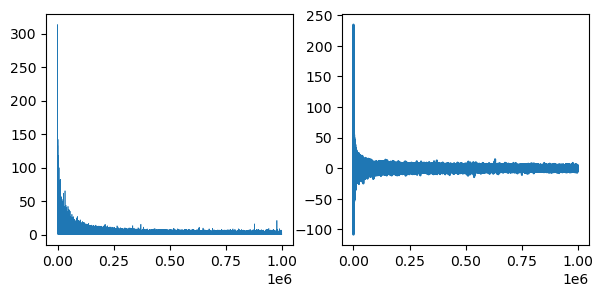

In [159]:
# create random game states and then train a network to predict current hand score...
def generateRandomHand(dominoes, numDominoes, numPlayers, verboseOutput=False):
    numInHands = np.random.randint(numDominoes+1)
    idxInHands = np.random.choice(numDominoes,numInHands,replace=False)
    handIdx = np.random.randint(0, numPlayers, numInHands)
    played = np.full(numDominoes, True)
    myHand = np.full(numDominoes, False)
    otherHands = np.full(numDominoes, False)
    played[idxInHands]=False
    myHand[idxInHands[handIdx==0]] = True
    otherHands[idxInHands[handIdx>0]] = True
    myHandValue = np.sum(dominoes[myHand])
    otherHandValue = np.sum(dominoes[otherHands])
    if verboseOutput:
        return played, myHand, otherHands, myHandValue, otherHandValue
    networkInput = (np.concatenate((played, myHand))*1)
    networkOutput = np.array([myHandValue, otherHandValue])
    # networkInput = np.concatenate((np.sum(dominoes.T * played, axis=0), np.sum(dominoes.T * myHand, axis=0)))
    return networkInput, networkOutput

# played, myHand, otherHands, myHandValue, otherHandValue = generateRandomHand(dominoes, numDominoes, numPlayers, verboseOutput=True)
networkInput, networkOutput = generateRandomHand(dominoes, numDominoes, numPlayers)

numPlayers = 3
highestDominoe = 9
numDominoes = df.numberDominoes(highestDominoe)
dominoes = df.listDominoes(highestDominoe)

handValueNetwork = dn.handValueNetwork(numPlayers,numDominoes,highestDominoe)
handValueNetwork.to(device)

numIterations = 1000000
target = np.zeros((numIterations, 2))
pred = np.zeros((numIterations, 2))
storeLoss = np.zeros(numIterations)

lossFunction = nn.L1Loss()
# optimizer = torch.optim.SGD(handValueNetwork.parameters(), lr=1e-2, momentum=0.5)
optimizer = torch.optim.Adadelta(handValueNetwork.parameters())

for ii in tqdm(range(numIterations)):
    networkInput, networkOutput = generateRandomHand(dominoes, numDominoes, numPlayers)
    target[ii] = np.copy(networkOutput)
    
    networkInput = torch.tensor(networkInput).to(device).float()
    networkOutput = torch.tensor(networkOutput).to(device).float()
    
    output = handValueNetwork(networkInput)
    
    loss = lossFunction(output, networkOutput)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    storeLoss[ii] = loss.item()
    pred[ii] = output.detach().cpu().numpy()
    
print(np.mean(storeLoss[-100:]))
fig,ax = plt.subplots(1,2,figsize=(7,3))
ax[0].plot(range(numIterations), storeLoss, linewidth=0.5)
ax[1].plot(range(numIterations), pred[:,0]-target[:,0])

In [ ]:
# Example of options list for current game (requires game.initializeHand() and game.presentGameState() to be run)
print(f"Line available: {game.available}, dummy available: {game.dummyAvailable}")
print(f"Penny-up: {game.cantPlay}, dummy playable: {game.dummyPlayable}")
print(f"Hand-size: {game.handSize}, manualHandSize: {[len(agent.myHand) for agent in game.agents]}")
print("")
game.agents[game.nextPlayer].gameState(game.played, game.available, game.handSize, game.cantPlay, game.didntPlay, game.turnCounter, game.dummyAvailable, game.dummyPlayable)
lineOptions, dummyOptions = game.agents[game.nextPlayer].playOptions()
df.printDominoeList(lineOptions, game.agents[game.nextPlayer].dominoes, name='line')
df.printDominoeList(dummyOptions, game.agents[game.nextPlayer].dominoes, name='dummy:')
dominoe, location = game.agents[game.nextPlayer].selectPlay()
if dominoe is not None:
    print(f"~{game.agents[game.nextPlayer].agentName}~ agent played dominoe: {dominoe}: {df.dominoesString(game.dominoes[dominoe])} on location: {location}.")
else:
    print(f"~{game.agents[game.nextPlayer].agentName}~ agent could not play!")
game.doTurn()